### HDS-M05: Deep Learning

Module Leaders: Bartek Papiez and Sharib Ali

Practical Leader: Bartek Papiez

Date: 3rd Nov. 2020


### Required packages
[1] [numpy](http://www.numpy.org) is package for scientific computing with python

[2] [h5py](http://www.h5py.org) is package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks


### Segmentation using Encoder-Decoder architecture: U-Net

[1] U-Net paper to read: https://arxiv.org/pdf/1505.04597.pdf

[2] U-Net presentation from Dr. Olaf Ronneber: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/


**What will you learn here?**

You will make an encoder-decoder U-Net architecture.

Start your exercise from single object segmentation (background and object)

Think about your goal, the error metric, in this exercise. How to quantify "good segmentation"? What measure you need?

Think about data augmentation for this network 

Think about optimisation for hyperparameters

Also if time permits, consider two (or more) object segmetantion problem - what do you need to change in the architecture? What about parameters? Cost function?

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" style="width:800px;height:400px;">
<caption><center> <u>Figure</u>: U-Net architecture for image segmentation.</center></caption>

**Concentrate on:**

[1] Encoder layers (this is similar to your classification exercise - see lecture on detection/segmentation, also think whether you can reuse any code from your clasification task)

[2] Decoder layers (we add upscaling of feature maps as we want to add spatial accuracy (localisation) to obtain pixel level segmentation)

In [3]:
import os
import sys
from glob import glob

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import imageio
from PIL import Image

In [78]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms   

import torchsummary

# always check your version
print(torch.__version__)

1.7.0


#### Build your model here

**Notice:**

- Each unit in both encoder and decoder has 2 convolutional layers (Conv2d), batch normalisation (BatchNorm2d) and activation function (ReLU)
- Downsampling is done after every unit in encoder
- Upsampling is done after every unit in the decoder layer
- Both upsampling and downsampling is followed by a double convolution layer
- Concatenation of features is done at 4 stages

If you search for other information, you may find slighly modified U-Net architecure, but during this tutorial you should rather focus on the basic model. 

In [79]:
# Step 1: Build a nn.Sequential 2 convolutional layers (Conv2d), batch normalisation (BatchNorm2d) and activation function (ReLU)

class layeredConv(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.layered_conv = nn.Sequential(
            nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel_out, channel_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.layered_conv(x)

In [80]:
# Step 2: Build a downscaling module using MaxPool2d [Hint: use the above layeredConv after that]

class downsamplePart(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            layeredConv(channel_in, channel_out)
        )
    def forward(self, x):
        return self.pool_conv(x)

In [81]:
# Step 3: Build a upscaling module using ConvTranspose2d 
# Also, concatenate with the previous feature maps so two inputs

class upsampledPart(nn.Module):
    def __init__(self, channel_in, channel_out, bilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=2, stride=2)
        self.conv = layeredConv(channel_in, channel_out)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2] )

        # concatenate
        x = torch.cat([x2, x1], dim=1)

        # 2-layered conv
        x = self.conv(x)

        return x

In [82]:
# Step 4: Output
# Notice only one convolution layer remains after 2 layered convs used in upsampling?

class outputLayer(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(outputLayer, self).__init__()
        self.conv = nn.Conv2d(channel_in, channel_out, kernel_size=1)
        
    def forward(self,x):
        return self.conv(x)  

In [83]:
# Step 5: Build your very own U-Net using the obove components 
# here output channel should be equal to number of classes 
class UNet(nn.Module):
    def __init__(self, channel_in, channel_out, bilinear=None):
        super(UNet, self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        
        self.initial = layeredConv(channel_in, 64)
        
        # downsampling layers with 2 conv layers
        self.down1 = downsamplePart(64, 128)
        self.down2 = downsamplePart(128, 256)
        self.down3 = downsamplePart(256, 512)
        self.down4 = downsamplePart(512, 1024)
        
        # upsampling layers with feature concatenation and 2 conv layers  
        self.up1 = upsampledPart(1024, 512)
        self.up2 = upsampledPart(512, 256)
        self.up3 = upsampledPart(256, 128)
        self.up4 = upsampledPart(128, 64)
        
        # output layer
        self.out = outputLayer(64, channel_out)

    def forward(self,x):
        # Downscale
        # Each output must be saved so it can be input into the upsampling parts
        x1 = self.initial(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Upscale
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # output
        x = self.out(x)
        
        return x  

In [104]:
# Note 1: your out channel should be equal to no of classes
# Note 2: your input channel should be equal to no of channels you have in image (e.g. 3 in RGB)
model = UNet(channel_in=3, channel_out=1)
#model

In [105]:
torchsummary.summary(model, (3, 512, 512), device="cpu") # Runs a basic test of the network. Very useful and clear!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
       layeredConv-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,856
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,584
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

### Prepare your data using pytorch 
-  Your data should return an image and a label pair
-  Image has to be normalised and transformed to a tensor (readable by PIL image)
-  both image and label should be loaded in your GPU

In [106]:
os.listdir('../datasets/train-val/')

['masks', 'images', 'kavsir_bboxes.json']

In [107]:
os.listdir('../datasets/train-val/images')

['cju7d1tvt25bu08019dvw3uff.jpg',
 'cju45rj7ln8980850a7821fov.jpg',
 'cju2mh8t6p07008350e01tx2a.jpg',
 'cju5x7iskmad90818frchyfwd.jpg',
 'cju7et17a2vjk0755e743npl1.jpg',
 'cju846ec0kj7z08012o10klrb.jpg',
 'cju6v5ilsv8hk0850rb5sgh6o.jpg',
 'cju2saez63gxl08559ucjq3kt.jpg',
 'cju3xuj20ivgp0818mij8bjrd.jpg',
 'cju2ro5jqsy680988pi6qsujw.jpg',
 'cju2t3ibkuecr0835o7si16zv.jpg',
 'cju5bbtwsa8cl0987wgfsqpao.jpg',
 'cju7f4sc62xqj075597xpmuoy.jpg',
 'cju8b7aqtr4a00987coba14b7.jpg',
 'cju2qxxko229x08786gvxxhur.jpg',
 'cju2yo1j1v0qz09934o0e683p.jpg',
 'cju31t8xd17bk0835rnb893jk.jpg',
 'cju2y8s56ymqr083541ggdsml.jpg',
 'cju2y5zas8m7f0801d34g5owq.jpg',
 'cju32pzh9bpw10855q4vaxfhe.jpg',
 'cju2m56cryvqd0801gtn2yp8t.jpg',
 'cju5xneamme2p0801qdf7fdwv.jpg',
 'cju7f6cqy2ur20818t1saazbm.jpg',
 'cju2nbdpmlmcj0993s1cht0dz.jpg',
 'cju1b75x63ddl0799sdp0i2j3.jpg',
 'cju88trl3ogi208716qvti51b.jpg',
 'cju8amfdtqi4x09871tygrgqe.jpg',
 'cju1amqw6p8pw0993d9gc5crl.jpg',
 'cju45jpvfn6c809873pv1i34s.jpg',
 'cju3y0pjrj1c

In [153]:
from PIL import Image
import os # to combine directories
from glob import glob

class myDataSet_Seg(object):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        
        # load all image files, sorting them to ensure that they are aligned
        self.img_ext = ".jpg"
        self.img_path = "images"
        self.mask_path = "masks"
        self.imgs = sorted(glob(os.path.join(root, self.img_path, f"*{self.img_ext}")))
        self.masks = sorted(glob(os.path.join(root, self.mask_path, f"*{self.img_ext}")))
        
        # convert to shape
        self.img_shape = (512, 512)
        
    def __getitem__(self, idx):
       
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
    
        img = Image.open(img_path)
        img = self.convert_img(img, np.float32)
        
        # Open masks
        mask = Image.open(mask_path)
        mask = self.convert_img(mask, np.uint8)
        # mask = mask > 100 # might help for binarisation
        
        # Optionally apply transforms
        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
   
        return img, mask
    
    def convert_img(self, img, dtype=np.float32):
        img = img.resize(self.img_shape, resample=0)
        img = np.asarray(img).astype(dtype)
        img = torch.Tensor(img)
        # Add channel dimension
        img = img.unsqueeze(0)
        return img
    
    def __len__(self):
        return len(self.imgs)   

## Explore data

In [1]:
img = Image.open("../datasets/train-val/images/cju0qkwl35piu0993l0dewei2.jpg")
img.resize((512,512), resample=0)

NameError: name 'Image' is not defined

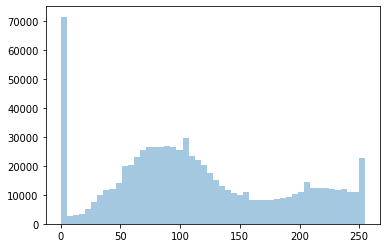

In [155]:
plt.figure()
sns.distplot(np.asarray(img.resize((512,512), resample=0)).ravel(), kde=False)
plt.show()

(529, 622, 3)


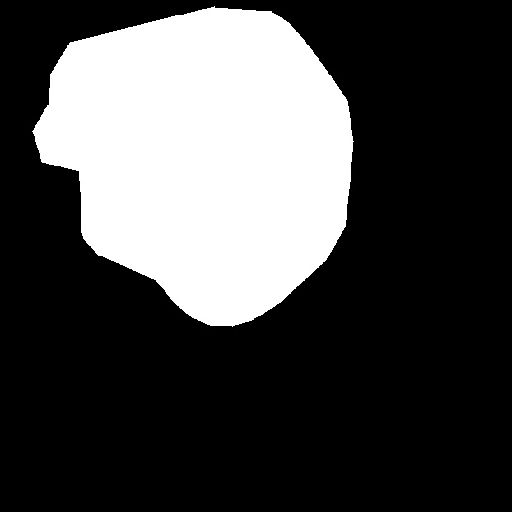

In [156]:
mask = Image.open("../datasets/train-val/masks/cju0qkwl35piu0993l0dewei2.jpg")
print(np.array(mask).shape)
mask.resize((512,512), resample=0)

In [157]:
np.unique(mask)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8, 247, 248, 249, 250,
       251, 252, 253, 254, 255], dtype=uint8)

In [158]:
# Don't use these at the moment, improved performance can likely be gained by adding augmentation to training data
transform = transforms.Compose([ 
    transforms.RandomResizedCrop((256, 256)), transforms.ToTensor()])

In [159]:
train_dst = myDataSet_Seg(root='../datasets/train-val')#, transforms=transform)

# use dataloader to compile batches for your training
# from torch.utils import data
indices = torch.randperm(len(train_dst)).tolist()

# divide your data into train and validation sets (80:20 split)
split_i = len(train_dst) - (len(train_dst) // 5)
dataset_train = torch.utils.data.Subset(train_dst, indices[:split_i])
dataset_val = torch.utils.data.Subset(train_dst, indices[split_i:])
print(len(indices), len(dataset_train), len(dataset_val))
set(indices[:split_i]) & set(indices[split_i:])

1000 800 200


set()

In [160]:
train_iter = iter(dataset_train)
img, mask = next(train_iter)
print(img.shape, mask.shape)

torch.Size([1, 512, 512, 3]) torch.Size([1, 512, 512, 3])


In [161]:
# np.ma.masked_where stops the background from being plotted
masked_mask = np.ma.masked_where(np.asarray(mask) == 0, mask)

plt.figure()
plt.imshow(img[0], cmap="gray")
plt.imshow(masked_mask[0], cmap="winter", alpha=0.3, vmin=0, vmax=3)
#plt.imshow(masked_mask[1], cmap="winter", alpha=0.3, vmin=-2, vmax=1)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: Unsupported dtype

<Figure size 432x288 with 1 Axes>

## Metrics

In [162]:
# Create metrics
def dice(a, b):
    """Calculate dice score for each image in tensor"""
    # a and b are tensors of shape (B, C, H, W)
    # Sum over last two axes (H and W i.e. each image)
    return 2*(a*b).sum(axis=[-2, -1])/(a + b).sum(axis=[-2,-1])

def mask_out(out):
    """Mask tensor/array with 0 threshold"""
    # Need to binarize the output to be able to calculate dice score
    return out > 0

def get_dice_arr(out, label):
    """Get dice score for each image in the batch for each mask seperately"""
    # Output is shape (B, C)
    return dice(mask_out(out), label)

## Model and optimiser

In [163]:
# Greyscale image in (1 channel) and Left and Right predictions out (2 channels)
model = UNet(channel_in=3, channel_out=1)

In [164]:
# Create a dataloader using pytorch function
batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, num_workers=3)

In [165]:
# set your optimiser and loss function 
lr = 0.001

# Can use a variety of different optimisers
# Adam worked well
optimiser = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-8)
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')

In [166]:
# print trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable parameters is:', pytorch_total_params)

Trainable parameters is: 31043521


## Training Loop

In [167]:
epochs = 30
device = 'cuda'
model = model.to(device)
history = {"train_loss": [], "val_loss": [], "train_dice": [], "val_dice": []}

for epoch in range(epochs):
    train_loss = []
    train_dice = []
    model.train()
    for (images, labels) in (train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimiser.zero_grad()
        out = model(images)
        #out = torch.argmax(out, 1) 
        loss = criterion(out, labels) 
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
        
        dice_scores_arr = get_dice_arr(out, labels.to(device))
        train_dice.append(dice_scores_arr.mean(axis=0).detach().cpu().numpy())
        
        # Delete tensors to save GPU memory
        del images
        del labels
        del out
        
    model.eval()
    val_loss = []
    val_dice = []
    # B, C, H, W
    for val_img, val_labels in val_loader:
        val_out = model(val_img.to(device))
        val_loss.append(criterion(val_out, val_labels.to(device)).item())
        
        dice_scores_arr = get_dice_arr(val_out, val_labels.to(device))
        val_dice.append(dice_scores_arr.mean(axis=0).detach().cpu().numpy())
        
        del val_img
        del val_labels
        del val_out

    val_dice = np.array(val_dice)
    history["train_loss"].append(np.mean(train_loss))
    history["val_loss"].append(np.mean(val_loss))
    history["train_dice"].append(np.mean(train_dice, axis=0))
    history["val_dice"].append(np.mean(val_dice, axis=0))
    
    print(f'Epoch {epoch}: '
          f'train_loss {history["train_loss"][-1]:.4f}, '
          f'val_loss {history["val_loss"][-1]:.4f}, '
          f'train_dice: L {history["train_dice"][-1][0]:.3f} R {history["train_dice"][-1][1]:.3f}, '
          f'val_dice: L {history["val_dice"][-1][0]:.3f} R {history["val_dice"][-1][1]:.3f}')
    

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 5-dimensional input of size [5, 1, 512, 512, 3] instead

## Show training history
It's a bit unstable - in other experiments, reducing the learning rate and training for more epochs helped improve the model further

In [ ]:
# Tensorboard would be better for this but this was simpler for now
plt.figure(figsize=(6.5,4))
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.ylabel("Loss")
plt.legend(loc="upper right", frameon=False)
plt.show()

train_dice = np.array(history["train_dice"])
val_dice = np.array(history["val_dice"])

titles = ["L", "R"]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.plot(train_dice[:, i], label=f"Train")
    ax.plot(val_dice[:, i], label="Val")
    ax.set_ylabel("Dice Score")
    ax.legend(loc="upper right", frameon=False)
    ax.set_ylim([0, 1])
    ax.set_title(titles[i])
plt.tight_layout()
plt.show()


## Check example validation image

In [51]:
val_iter = iter(dataset_val)
img, mask = next(val_iter)
img.shape, mask.shape

(torch.Size([1, 512, 512]), torch.Size([2, 512, 512]))

In [52]:
img, mask = next(val_iter)

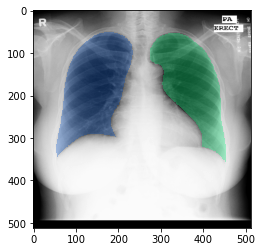

In [53]:
masked_mask = np.ma.masked_where(np.asarray(mask) == 0, mask)

plt.figure()
plt.imshow(img[0], cmap="gray")
plt.imshow(masked_mask[0], cmap="winter", alpha=0.3, vmin=0, vmax=3)
plt.imshow(masked_mask[1], cmap="winter", alpha=0.3, vmin=-2, vmax=1)
plt.show()

out = model(img.unsqueeze(0).to(device))
out_img = out.cpu().detach().numpy()[0,:,:,:]
out_mask = out_img > 0
masked_out = np.ma.masked_where(out_mask == 0, out_img)

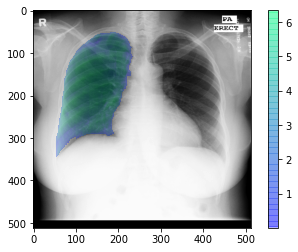

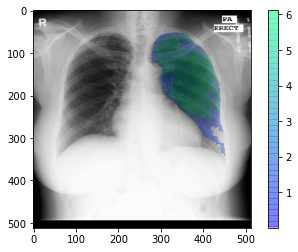

In [54]:
plt.figure()
plt.imshow(img[0], cmap="gray")
plt.imshow(masked_out[0], cmap="winter", alpha=0.3)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(img[0], cmap="gray")
plt.imshow(masked_out[1], cmap="winter", alpha=0.3)
plt.colorbar()
plt.show()

/cdthome/pzf164/.conda/envs/pytorch/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


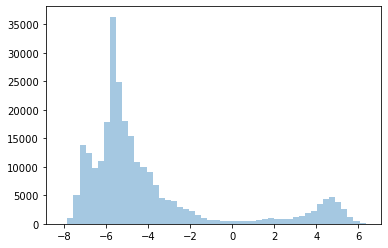

In [55]:
plt.figure()
sns.distplot(out_img[0], kde=False)
plt.show()


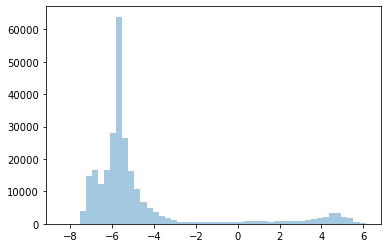

In [56]:
plt.figure()
sns.distplot(out_img[1], kde=False)
plt.show()